# Customer Purchase Prediction for Rainbow Store 

This set of retail spending data is great practice both for defining our own prediction problem (known as [prediction engineering](http://ieeexplore.ieee.org/document/7796929/)), and for using some of the time-based capabilities of Featuretools, notably cutoff times. Whenever we have time-series data, we need to be extra careful to not "leak labels" or use information from the future to predict a past event. Usually, when we're doing manual feature engineering, this can be an issue and often, a system will work well in development but utterly fail when deployed because it was trained on invalid data. Fortunately, Featuretools will take care of the time issue for us, creating a rich set of features that obey the time restrictions.

The code is available at [my Github repo](http://ieeexplore.ieee.org/document/7796929/). 

## Roadmap 

Following is an outline for this notebook:

1. Read in data, inspect, and clean
2. Basic exploratory analysis
    * Cohort analysis 
2. Develop a prediction problem
    * Create a dataframe of labels - what we want to predict, and cutoff times - the point that all data must come before for predicting a label
3. Using [Featuretools](https://docs.featuretools.com/#minute-quick-start) for automated feature engineering
    * Normalize the original table to develop new tables 
    * Specify primitives with maximum depth of features
    * Use the cutoff times to make features using valid data for each label
4. Use the features to train a machine learning model
    * Train model
    * Measure performance of the model
5. Explain model with SHAP 
5. Next steps

Our work will go through some basic explonatory data analysis and focus heavily on the process for predictive modelling (labeling, feature engineering and selection, modeling, model explanation).We should be good to go!!!!

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

# Automated feature engineering
import featuretools as ft

### Load in Data and Examine

The raw data is a collection of purchases from Rainbow Store collected in 02/2018-06/2018. The original data has delivered in form of csv file with json format. Use PowerBI with data transformation tools allows to flatten the given dataset which should be ready for processing easilly.

Each row in the new data represents one product that was purchased forming an order. The data is quite cleaned. 

In [2]:
rainbow_df = pd.read_excel('../01-data-cleaned/VinIDRecruitChallenge_MLTrack_DataSet.xlsx')
rainbow_df.dtypes

csn                                       object
date                              datetime64[ns]
transaction_info.article                   int64
transaction_info.salesquantity           float64
transaction_info.price                   float64
dtype: object

#### Rename columns

To be easier for analysis, we change name of some columns.

In [4]:
columns_name = ['customerid', 'txn_date', 'article', 'sale_quantity', 'price']
rainbow_df.columns = columns_name

#### Convert Data to Correct Types

In [5]:
rainbow_df['article'] = str(rainbow_df['article'])

#### Remove Duplicates 

In [6]:
#remove duplicates 
rainbow_df = rainbow_df.drop_duplicates()

#### Missing Values

There is no missing value in the dataset, we good to go for the next steps.

In [7]:
rainbow_df.isnull().sum()

customerid       0
txn_date         0
article          0
sale_quantity    0
price            0
dtype: int64

### Basic exploratory analysis

Why is retention analysis important?

In [8]:
## Define cohorts by the month of the first order
# Take the first order date per customer
cohorts_df = rainbow_df.groupby('customerid')['txn_date'] \
                       .agg('min') \
                       .pipe(pd.DataFrame)

# Customerid is in the index
# Create a column with the customerid
cohorts_df = cohorts_df.reset_index()

# Extract the month from the order date
def get_month(date):
    return(date.month)

cohorts_df['join_month'] = cohorts_df['txn_date'].apply(lambda x: get_month(x))

# Drop the date column
cohorts_df = cohorts_df.drop('txn_date', axis = 1)

# Each customer Id is associated with the month
# they first purchased (join_month) - that is also
# the cohort ID

## Count cohort sizes
cohort_sizes_df = cohorts_df.groupby('join_month')['customerid'] \
                            .agg('count') \
                            .rename('cohort_size') \
                            .pipe(pd.DataFrame) \
                            .reset_index()

## Update the raw data with cohort_id and activity_index

df = pd.merge(rainbow_df, cohorts_df, how = 'inner',
                                      left_on = 'customerid',
                                      right_on = 'customerid')

# Add the activity month and index
df['activity_month'] = df['txn_date'].apply(lambda x: get_month(x))
df['activity_index'] = df['activity_month'] - df['join_month']

# Make sure there is a max of one row per customer per month
# (customers who came back at least once in a month)
df = df[['customerid', 'join_month', 'activity_index']].drop_duplicates()

## Get the number of returning customers

# Count the number of returning customers
# per cohort, per month

activity_size_df = df.groupby(['join_month', 'activity_index'])['customerid'] \
                     .agg('count') \
                     .rename('activity_size') \
                     .pipe(pd.DataFrame) \
                     .reset_index()

## Calculate the retention rate
# per month after activation for each cohort

retention_df = pd.merge(cohort_sizes_df,activity_size_df,how = 'inner',
                                                         left_on = 'join_month',
                                                         right_on = 'join_month')


retention_df['retention_rate'] = round(retention_df['activity_size'] / retention_df['cohort_size'], 2)

## reindex the DataFrame
cohorts = retention_df.copy()
#cohorts.reset_index(inplace=True)
cohorts.set_index(['join_month', 'activity_index'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['activity_size'].groupby(level=0).first()

#get percent retention
user_retention = cohorts['activity_size'].unstack(0).divide(cohort_group_size, axis=1)

In [9]:
user_retention

join_month             2         3       4         5    6
activity_index                                           
0               1.000000  1.000000  1.0000  1.000000  1.0
1               0.564642  0.364186  0.2752  0.261695  NaN
2               0.538585  0.336358  0.2488       NaN  NaN
3               0.515835  0.306715     NaN       NaN  NaN
4               0.496292       NaN     NaN       NaN  NaN

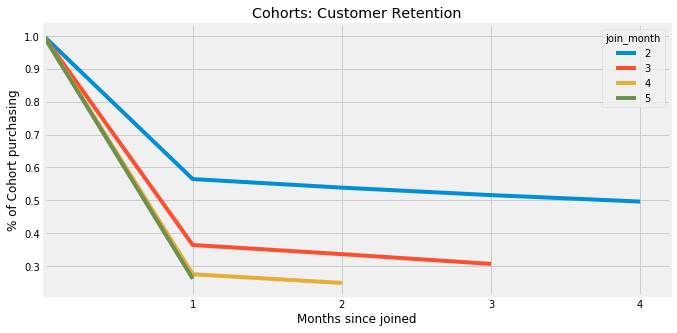

In [10]:
user_retention[[2,3,4,5]].plot(figsize=(10,5))
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 4.1, 1))
plt.xlim(0, 4.2)
plt.ylabel('% of Cohort purchasing')
plt.xlabel('Months since joined');

From the analysis, we get some point as following:

1. Tỷ lệ khách hàng giữ lại được sau một tháng cực kì thấp, số lượng khách hàng mới tại tháng 1 là cao vượt trội so với các tháng khác
2. Xem lại Customer onboarding 

### Prediction Problem

Build Meaningful Features and Prevent Data Leakage......

#### Making Labels

The function below takes in a start date ...

In [11]:
#do not touch the dataset
cleaned_data = rainbow_df.copy()

#get transaction month 
cleaned_data['txn_month'] = cleaned_data['txn_date'].apply(lambda x: x.strftime('%Y-%m'))

#change txn_month type to datetime
cleaned_data['txn_month'] = pd.to_datetime(cleaned_data['txn_month'])

In [12]:
#separate txn month to be easier for manipulation
data_lebeled = cleaned_data[['customerid','txn_month']].drop_duplicates()

##### Label for individual customer

Making label for one customer

In [13]:
#label for individual customer 
def label_customer(customer_id, customer_transactions):
    
    # Don't modify original
    transactions = customer_transactions.copy()
    
    #set evaluation for txn < '2018-05'
    transactions['is_eval'] = (transactions['txn_month'] < '2018-05-01')

    #define churn or not churn
    transactions['exp_txn_month'] = transactions['txn_month'] + pd.DateOffset(months=2)
    transactions['txn_month_one_shift'] = transactions['txn_month'].shift(-1)
    transactions['txn_month_two_shift'] = transactions['txn_month'].shift(-2)

    transactions['is_churned'] = ((transactions['exp_txn_month'] != transactions['txn_month_one_shift']) & 
                                        (transactions['exp_txn_month'] != transactions['txn_month_two_shift']))
    

    return transactions[['customerid', 'txn_month', 'is_eval', 'is_churned']].copy()

Testing on specific customer

In [14]:
CUSTOMER_ID = data_lebeled.iloc[1111,0]
customer_transactions = data_lebeled.loc[data_lebeled['customerid'] == CUSTOMER_ID].copy()

label_times = label_customer(CUSTOMER_ID, customer_transactions)
label_times

customerid  txn_month  is_eval  is_churned
21595  Y2Rna2ZrZw== 2018-02-01     True        True
21608  Y2Rna2ZrZw== 2018-05-01    False        True

It works!!!

##### Label for all customer

Function -- chú ý quá trình xây dựng các biến như is_eval và is_churned......

In [15]:
#Churn for all customers
def make_label_times(transactions):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
       
    Return
    --------
        label_times (dataframe): a table with customerids, txn_month, is_eval, is_churned
    """
    
    label_times = []
    transactions = transactions.sort_values(['customerid', 'txn_month'])
    
    # Iterate through each customer and find labels
    for customer_id, customer_transactions in transactions.groupby('customerid'):
        lt_cust = label_customer(customer_id, customer_transactions)
        
        label_times.append(lt_cust)
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

Make the label for all customer

In [16]:
label_times = make_label_times(data_lebeled)

Get the final dataset. 

Choose 'is_eval'==True for selecting eligible observations.

In [17]:
#Get the final dataset
ml_data = pd.merge(cleaned_data, label_times,  how='left', left_on=['customerid','txn_month'], right_on = ['customerid','txn_month'])
#As we stated before, we only select customer who has maximum transdate <= '2018-04'
ml_data = ml_data[ml_data['is_eval']==True].drop('is_eval', axis=1)

 ### Using Featuretools for automated feature engineering

Create dataset for featuretools....

In [19]:
#Feature dataset
ft_data = ml_data.drop(['txn_month', 'is_churned'], axis=1)
ft_data = ft_data.reset_index()

Create label dataset

In [20]:
#create label data 
label = ml_data[['customerid', 'txn_month', 'is_churned']]

#change cut-off time for futher engineering
label.rename(columns={'txn_month':'cutoff_time', 'is_churned':'label'}, inplace=True)
label['cutoff_time'] = label['cutoff_time'] + pd.DateOffset(months=1)

# convert to binary value
label['label'] = label['label'].astype(int)

#remove duplicates
label.drop_duplicates(inplace=True)

##### Create entities

In [21]:
#Featuretools
es = ft.EntitySet(id="Rainbow Store")

# Add the entire data table as an entity
es.entity_from_dataframe("purchases",
                         dataframe=ft_data,
                         index="purchases_index",
                         time_index = 'txn_date')

#Normalizing entities
# create a new "products" entity
es.normalize_entity(new_entity_id="article_names",
                    base_entity_id="purchases",
                    index="article")

# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="purchases",
                    index="customerid")

## create a new "orders" entity
#es.normalize_entity(new_entity_id="orders",
#                    base_entity_id="purchases",
#                    index="index")

2019-04-15 21:36:11,742 featuretools.entityset - WARNING    index purchases_index not found in dataframe, creating new integer column


Entityset: Rainbow Store
  Entities:
    purchases [Rows: 585375, Columns: 7]
    article_names [Rows: 1, Columns: 2]
    customers [Rows: 15784, Columns: 2]
  Relationships:
    purchases.article -> article_names.article
    purchases.customerid -> customers.customerid

##### Using Primatives with highest depth

In [22]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       agg_primitives = ['std', 'max', 'min', 'mode',
                                                         'mean', 'skew', 'last', 'avg_time_between'],
                                       trans_primitives = ['cum_sum', 'cum_mean', 'day', 
                                                           'month', 'hour', 'weekend'],
                                       n_jobs = -1, chunk_size = 100, max_depth = 2,
                                       cutoff_time = label, cutoff_time_in_index = True,
                                       verbose = 1)

Built 184 features
2019-04-15 21:36:15,337 featuretools.computational_backend - WARNING    Worker memory is between 1 to 2 times the memory size of the EntitySet. If errors occur that do not occur with n_jobs equals 1, this may be the cause.  See https://docs.featuretools.com/guides/parallel.html for more information.
EntitySet scattered to workers in 17.344 seconds
Elapsed: 04:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 281/281 chunks


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/hoducninh/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:32968 remote=tcp://127.0.0.1:45995>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:32986 remote=tcp://127.0.0.1:45995>
Exception ignored in: <generator object add_client at 0x7f39115ac678>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/hoducninh/anaconda3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 177, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/hoducninh/anaconda3/lib/pytho

Remove features related to 'purchases_index'

In [23]:
# Iterate through the columns
for col in list(feature_matrix.columns):
    # Select columns that should be numeric
    if ('index' in col):
        # Convert the data type to float
        feature_matrix.drop(col, axis=1, inplace=True)
        
# Drop some more features
feature_matrix.drop(columns = ['MODE(purchases.article)', 'LAST(purchases.article)'], inplace = True)

In [24]:
feature_matrix.head(3)

STD(purchases.sale_quantity)  STD(purchases.price)  \
customerid   time                                                             
Y2NgaWlpYA== 2018-03-01                      1.204159         101126.358445   
Y2NgamRpZA== 2018-03-01                      0.566264          91006.855807   
Y2NgbWFn     2018-03-01                      1.610406          24654.705545   

                         MAX(purchases.sale_quantity)  MAX(purchases.price)  \
customerid   time                                                             
Y2NgaWlpYA== 2018-03-01                           4.0             295000.00   
Y2NgamRpZA== 2018-03-01                           3.0             499901.23   
Y2NgbWFn     2018-03-01                           6.0              99000.00   

                         MIN(purchases.sale_quantity)  MIN(purchases.price)  \
customerid   time                                                             
Y2NgaWlpYA== 2018-03-01                         1.000                3900.0   
Y2NgamRpZA== 2018-03-01                         0.162                4000.0   
Y2NgbWFn     2018-03-01                         1.000                3900.0   

                         MEAN(purchases.sale_quantity)  MEAN(purchases.price)  \
customerid   time                                                               
Y2NgaWlpYA== 2018-03-01                       1.625000           83601.562500   
Y2NgamRpZA== 2018-03-01                       1.118933           48854.468667   
Y2NgbWFn     2018-03-01                       1.857143           20371.428571   

                         SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
customerid   time                                                               
Y2NgaWlpYA== 2018-03-01                       1.628182               1.244193   
Y2NgamRpZA== 2018-03-01                       1.524211               4.488398   
Y2NgbWFn     2018-03-01                       1.815523               2.815737   

                         ...  \
customerid   time        ...   
Y2NgaWlpYA== 2018-03-01  ...   
Y2NgamRpZA== 2018-03-01  ...   
Y2NgbWFn     2018-03-01  ...   

                         CUM_MEAN(MAX(purchases.price) by LAST(purchases.article))  \
customerid   time                                                                    
Y2NgaWlpYA== 2018-03-01                                      295000.000000           
Y2NgamRpZA== 2018-03-01                                      397450.615000           
Y2NgbWFn     2018-03-01                                      297967.076667           

                         CUM_MEAN(STD(purchases.sale_quantity) by LAST(purchases.article))  \
customerid   time                                                                            
Y2NgaWlpYA== 2018-03-01                                           1.204159                   
Y2NgamRpZA== 2018-03-01                                           0.885212                   
Y2NgbWFn     2018-03-01                                           1.126943                   

                         CUM_MEAN(SKEW(purchases.sale_quantity) by MODE(purchases.article))  \
customerid   time                                                                             
Y2NgaWlpYA== 2018-03-01                                           1.628182                    
Y2NgamRpZA== 2018-03-01                                           1.576197                    
Y2NgbWFn     2018-03-01                                           1.655972                    

                         CUM_MEAN(LAST(purchases.price) by LAST(purchases.article))  \
customerid   time                                                                     
Y2NgaWlpYA== 2018-03-01                                      160000.000000            
Y2NgamRpZA== 2018-03-01                                      108400.000000            
Y2NgbWFn     2018-03-01                                       79033.333333            

                         CUM_MEAN(AVG_TIME_BETWEEN

##### Feature Selection 

At this point, we might want to apply some feature selection to our `feature_matrix`. It's likely that many of the features are highly correlated which can have a negative impact on model performance. 

The following call removes:

* Any features with more than 90% missing values 
* Any features with only a single unique value
* One out of every pair of columns with a correlation greater than 0.9.

In [29]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

In [30]:
#deep copy featue_matrix
df_ml = feature_matrix.copy()

#Get dummy data
df_ml = pd.get_dummies(df_ml).reset_index()
  
#feature selection 
feature_matrix_selection = feature_selection(df_ml.drop(columns = ['customerid','time']), missing_threshold=80, correlation_threshold=0.75)

#get the final feature matrix
feature_matrix_selection['time'] = df_ml['time']
feature_matrix_selection['customerid'] = df_ml['customerid']

Original shape:  (27996, 129)
0 missing columns with threshold: 80.
4 zero variance columns.
85 collinear columns removed with threshold: 0.75.
Total columns removed:  89
Shape after feature selection: (27996, 40).


In [31]:
feature_matrix_selection.head(3)

STD(purchases.sale_quantity)  STD(purchases.price)  \
0                      1.204159         101126.358445   
1                      0.566264          91006.855807   
2                      1.610406          24654.705545   

   MIN(purchases.sale_quantity)  MIN(purchases.price)  \
0                         1.000                3900.0   
1                         0.162                4000.0   
2                         1.000                3900.0   

   SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
0                       1.628182               1.244193   
1                       1.524211               4.488398   
2                       1.815523               2.815737   

   LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
0               160000.0                              0.000000   
1                56800.0                          74482.758621   
2                20300.0                              0.000000   

   DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
0                         27                            2  ...   
1                          1                            2  ...   
2                         22                            2  ...   

   CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
0                                                1.0                    
1                                                1.0                    
2                                                1.0                    

   CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500            
1                                       66228.015583            
2                                       50942.486579            

   CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
0                                      101126.358445           
1                                       96066.607126           
2                                       72262.639932           

   CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
0                                           1.628182                    
1                                           1.576197                    
2                                           1.655972                    

   CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
0                                      160000.000000            
1                                      108400.000000            
2                                       79033.333333            

   CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
0                                           1.244193            
1                                           2.866295            
2                                           2.849442            

   CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  \
0                                           0.000000                           
1                                       37241.379310                           
2                                       24827.586207                           

   label       time    customerid  
0      1 2018-03-01  Y2NgaWlpYA==  
1      1 2018-03-01  Y2NgamRpZA==  
2      0 2018-03-01      Y2NgbWFn  

[3 rows x 42 columns]

## Custom Primitives

__Custom primitives__ allow us to expand on the capabilities of Featuretools by writing functions that use our domain knowledge. __Featuretools will stack custom primitives allowing us to effectively amplify any previous experience we have with the problem.__

In [32]:
from featuretools.primitives import make_agg_primitive

##### The first customize primitives 

In [33]:
def total_previous_month(numeric, datetime, time):
    """Return total of `numeric` column in the month prior to `time`."""
    df = pd.DataFrame({'value': numeric, 'time': datetime})
    previous_month = time.month - 1
   
    # Handle special month
    if previous_month == 0:
        previous_month = 12
        previous_year = time.year - 1
        
        # Filter data
        df = df[(df['time'].dt.month == previous_month) & (df['time'].dt.year == previous_year)]
        
    else:
        df = df[df['time'].dt.month == previous_month]
        
    # Sum up total
    total = df['value'].sum()
    
    return total

In [34]:
total_previous = make_agg_primitive(total_previous_month, input_types = [ft.variable_types.Numeric,
                                                                         ft.variable_types.Datetime],
                                    return_type = ft.variable_types.Numeric,
                                    uses_calc_time = True)

In [35]:
feature_matrix_custom, feature_names_custom = ft.dfs(entityset=es, target_entity='customers',
                                                     cutoff_time = label, 
                                                     cutoff_time_in_index = True, 
                                                     agg_primitives = [total_previous], 
                                                     trans_primitives = [], chunk_size = len(label),
                                                     verbose = 1, n_jobs = 4)
feature_matrix_custom.head()

Built 3 features
EntitySet scattered to workers in 4.141 seconds
Elapsed: 03:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/hoducninh/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


TOTAL_PREVIOUS_MONTH(purchases.price, txn_date)  \
customerid   time                                                          
Y2NgaWlpYA== 2018-03-01                                       1337625.00   
Y2NgamRpZA== 2018-03-01                                       1465634.06   
Y2NgbWFn     2018-03-01                                        285200.00   
Y2NgcGlqZQ== 2018-03-01                                        895999.74   
Y2NgcWdmZA== 2018-03-01                                        806500.00   

                         TOTAL_PREVIOUS_MONTH(purchases.index, txn_date)  \
customerid   time                                                          
Y2NgaWlpYA== 2018-03-01                                              168   
Y2NgamRpZA== 2018-03-01                                             1245   
Y2NgbWFn     2018-03-01                                             2471   
Y2NgcGlqZQ== 2018-03-01                                             8532   
Y2NgcWdmZA== 2018-03-01                                             2841   

                         TOTAL_PREVIOUS_MONTH(purchases.sale_quantity, txn_date)  \
customerid   time                                                                  
Y2NgaWlpYA== 2018-03-01                                             26.000         
Y2NgamRpZA== 2018-03-01                                             33.568         
Y2NgbWFn     2018-03-01                                             26.000         
Y2NgcGlqZQ== 2018-03-01                                             21.556         
Y2NgcWdmZA== 2018-03-01                                              6.000         

                         label  
customerid   time               
Y2NgaWlpYA== 2018-03-01      1  
Y2NgamRpZA== 2018-03-01      1  
Y2NgbWFn     2018-03-01      0  
Y2NgcGlqZQ== 2018-03-01      0  
Y2NgcWdmZA== 2018-03-01      1

We can merge pandas dataframes using keys. Here we'll want to merge the features on the customer and the time (which is the cutoff time).

In [36]:
feature_matrix_custom.drop(columns = ['label'], inplace = True)
feature_matrix_custom.reset_index(inplace = True)

In [43]:
feature_matrix_new_selection = feature_matrix_selection.merge(feature_matrix_custom, on = ['customerid', 'time'], 
                                                          how = 'left')

##### The second customize primitives 

In [37]:
# The 2rd Primitives
def total_last_two_month(numeric, datetime, time):
    """Return total of `numeric` column in the month prior to `time`."""
    df = pd.DataFrame({'value': numeric, 'time': datetime})
    previous_month = time.month - 2
   
    # Handle special month
    if previous_month == 0:
        previous_month = 12
        previous_year = time.year - 1
        
        # Filter data
        df = df[(df['time'].dt.month == previous_month) & (df['time'].dt.year == previous_year)]
        
    else:
        df = df[df['time'].dt.month == previous_month]
        
    # Sum up total
    total = df['value'].sum()
    
    return total

In [38]:
total_two_previous = make_agg_primitive(total_last_two_month, input_types = [ft.variable_types.Numeric,
                                                                         ft.variable_types.Datetime],
                                    return_type = ft.variable_types.Numeric,
                                    uses_calc_time = True)

In [39]:
feature_matrix_2rd_custom, feature_names_2rd_custom = ft.dfs(entityset=es, target_entity='customers',
                                                     cutoff_time = label, 
                                                     cutoff_time_in_index = True, 
                                                     agg_primitives = [total_two_previous], 
                                                     trans_primitives = [], chunk_size = len(label),
                                                     verbose = 1, n_jobs = 4)
feature_matrix_2rd_custom.head()

Built 3 features


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59742 remote=tcp://127.0.0.1:39947>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59746 remote=tcp://127.0.0.1:39947>


EntitySet scattered to workers in 4.156 seconds
Elapsed: 02:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/hoducninh/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


TOTAL_LAST_TWO_MONTH(purchases.price, txn_date)  \
customerid   time                                                          
Y2NgaWlpYA== 2018-03-01                                              0.0   
Y2NgamRpZA== 2018-03-01                                              0.0   
Y2NgbWFn     2018-03-01                                              0.0   
Y2NgcGlqZQ== 2018-03-01                                              0.0   
Y2NgcWdmZA== 2018-03-01                                              0.0   

                         TOTAL_LAST_TWO_MONTH(purchases.index, txn_date)  \
customerid   time                                                          
Y2NgaWlpYA== 2018-03-01                                                0   
Y2NgamRpZA== 2018-03-01                                                0   
Y2NgbWFn     2018-03-01                                                0   
Y2NgcGlqZQ== 2018-03-01                                                0   
Y2NgcWdmZA== 2018-03-01                                                0   

                         TOTAL_LAST_TWO_MONTH(purchases.sale_quantity, txn_date)  \
customerid   time                                                                  
Y2NgaWlpYA== 2018-03-01                                                0.0         
Y2NgamRpZA== 2018-03-01                                                0.0         
Y2NgbWFn     2018-03-01                                                0.0         
Y2NgcGlqZQ== 2018-03-01                                                0.0         
Y2NgcWdmZA== 2018-03-01                                                0.0         

                         label  
customerid   time               
Y2NgaWlpYA== 2018-03-01      1  
Y2NgamRpZA== 2018-03-01      1  
Y2NgbWFn     2018-03-01      0  
Y2NgcGlqZQ== 2018-03-01      0  
Y2NgcWdmZA== 2018-03-01      1

In [40]:
feature_matrix_2rd_custom.drop(columns = ['label'], inplace = True)
feature_matrix_2rd_custom.reset_index(inplace = True)

In [44]:
feature_matrix_final_selection = feature_matrix_new_selection.merge(feature_matrix_2rd_custom, on = ['customerid', 'time'], 
                                                                  how = 'left')

In [45]:
#####Get the final featured dataset
final_matrix_selection = feature_selection(feature_matrix_final_selection.drop(columns = ['customerid','time']), 
                                                   missing_threshold=80, correlation_threshold=0.75 )

final_matrix_selection['time'] = feature_matrix_final_selection['time']
final_matrix_selection['customerid'] = feature_matrix_final_selection['customerid']

final_matrix_selection.head()

Original shape:  (27996, 46)
0 missing columns with threshold: 80.
0 zero variance columns.
6 collinear columns removed with threshold: 0.75.
Total columns removed:  6
Shape after feature selection: (27996, 40).


STD(purchases.sale_quantity)  STD(purchases.price)  \
0                      1.204159         101126.358445   
1                      0.566264          91006.855807   
2                      1.610406          24654.705545   
3                      0.629124          36938.708811   
4                      0.000000          91078.217301   

   MIN(purchases.sale_quantity)  MIN(purchases.price)  \
0                         1.000                3900.0   
1                         0.162                4000.0   
2                         1.000                3900.0   
3                         0.048                2700.0   
4                         1.000               35000.0   

   SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
0                       1.628182               1.244193   
1                       1.524211               4.488398   
2                       1.815523               2.815737   
3                       0.746580               0.759475   
4                       0.000000               0.109198   

   LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
0               160000.0                              0.000000   
1                56800.0                          74482.758621   
2                20300.0                              0.000000   
3                95000.0                          80441.379310   
4                35000.0                              0.000000   

   DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
0                         27                            2  ...   
1                          1                            2  ...   
2                         22                            2  ...   
3                          2                            2  ...   
4                          4                            2  ...   

   CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
0                                             1.0000                    
1                                             1.0000                    
2                                             1.0000                    
3                                             0.7720                    
4                                             0.8176                    

   CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500            
1                                       66228.015583            
2                                       50942.486579            
3                                       47401.862768            
4                                       64804.823548            

   CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
0                                      101126.358445           
1                                       96066.607126           
2                                       72262.639932           
3                                       63431.657152           
4                                       68960.969182           

   CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
0                                           1.628182                    
1                                           1.576197                    
2                                           1.655972                    
3                                           1.428624                    
4                                           1.142899                    

   CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
0                                      160000.000000            
1                                      108400.000000            
2                                       79033.333333            
3                                       83025.000000            
4                                       73420.000000            

   CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
0                                           1.244193      

We've get the dataset which is ready for modelling process.

In [86]:
#save data for modelling
#final_matrix_selection.to_csv('../01-data-cleaned/final_matrix_selection.csv')

### Modelling

#### Load data

In [3]:
final_matrix_selection = pd.read_csv('../01-data-cleaned/final_matrix_selection.csv').drop('Unnamed: 0', axis=1)

In [4]:
final_matrix_selection.head()

STD(purchases.sale_quantity)  STD(purchases.price)  \
0                      1.204159         101126.358445   
1                      0.566264          91006.855807   
2                      1.610406          24654.705545   
3                      0.629124          36938.708811   
4                      0.000000          91078.217301   

   MIN(purchases.sale_quantity)  MIN(purchases.price)  \
0                         1.000                3900.0   
1                         0.162                4000.0   
2                         1.000                3900.0   
3                         0.048                2700.0   
4                         1.000               35000.0   

   SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
0                       1.628182               1.244193   
1                       1.524211               4.488398   
2                       1.815523               2.815737   
3                       0.746580               0.759475   
4                       0.000000               0.109198   

   LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
0               160000.0                              0.000000   
1                56800.0                          74482.758621   
2                20300.0                              0.000000   
3                95000.0                          80441.379310   
4                35000.0                              0.000000   

   DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
0                         27                            2  ...   
1                          1                            2  ...   
2                         22                            2  ...   
3                          2                            2  ...   
4                          4                            2  ...   

   CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
0                                             1.0000                    
1                                             1.0000                    
2                                             1.0000                    
3                                             0.7720                    
4                                             0.8176                    

   CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500            
1                                       66228.015583            
2                                       50942.486579            
3                                       47401.862768            
4                                       64804.823548            

   CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
0                                      101126.358445           
1                                       96066.607126           
2                                       72262.639932           
3                                       63431.657152           
4                                       68960.969182           

   CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
0                                           1.628182                    
1                                           1.576197                    
2                                           1.655972                    
3                                           1.428624                    
4                                           1.142899                    

   CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
0                                      160000.000000            
1                                      108400.000000            
2                                       79033.333333            
3                                       83025.000000            
4                                       73420.000000            

   CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
0                                           1.244193      

#### Missing value

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values_table(final_matrix_selection)

Your selected dataframe has 42 columns.
There are 20 columns that have missing values.


Missing Values  \
SKEW(purchases.CUM_MEAN(sale_quantity by article))            1851   
SKEW(purchases.CUM_MEAN(price by customerid))                 1851   
SKEW(purchases.sale_quantity)                                 1851   
SKEW(purchases.price)                                         1851   
SKEW(purchases.CUM_MEAN(price by article))                    1851   
SKEW(purchases.CUM_MEAN(sale_quantity by custom...            1851   
SKEW(purchases.CUM_SUM(sale_quantity by article))             1851   
SKEW(purchases.CUM_SUM(price by customerid))                  1851   
CUM_SUM(AVG_TIME_BETWEEN(purchases.txn_date) by...             850   
CUM_SUM(STD(purchases.sale_quantity) by MODE(pu...             850   
STD(purchases.sale_quantity)                                   850   
STD(purchases.price)                                           850   
STD(purchases.CUM_MEAN(price by article))                      850   
STD(purchases.CUM_MEAN(sale_quantity by article))              850   
STD(purchases.CUM_SUM(price by customerid))                    850   
AVG_TIME_BETWEEN(purchases.txn_date)                           850   
CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(...              16   
CUM_MEAN(SKEW(purchases.price) by LAST(purchase...              16   
CUM_MEAN(STD(purchases.price) by MODE(purchases...               3   
CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) b...               3   

                                                    % of Total Values  
SKEW(purchases.CUM_MEAN(sale_quantity by article))                6.6  
SKEW(purchases.CUM_MEAN(price by customerid))                     6.6  
SKEW(purchases.sale_quantity)                                     6.6  
SKEW(purchases.price)                                             6.6  
SKEW(purchases.CUM_MEAN(price by article))                        6.6  
SKEW(purchases.CUM_MEAN(sale_quantity by custom...                6.6  
SKEW(purchases.CUM_SUM(sale_quantity by article))                 6.6  
SKEW(purchases.CUM_SUM(price by customerid))                      6.6  
CUM_SUM(AVG_TIME_BETWEEN(purchases.txn_date) by...                3.0  
CUM_SUM(STD(purchases.sale_quantity) by MODE(pu...                3.0  
STD(purchases.sale_quantity)                                      3.0  
STD(purchases.price)                                              3.0  
STD(purchases.CUM_MEAN(price by article))                         3.0  
STD(purchases.CUM_MEAN(sale_quantity by article))                 3.0  
STD(purchases.CUM_SUM(price by customerid))                       3.0  
AVG_TIME_BETWEEN(purchases.txn_date)                              3.0  
CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(...                0.1  
CUM_MEAN(SKEW(purchases.price) by LAST(purchase...                0.1  
CUM_MEAN(STD(purchases.price) by MODE(purchases...                0.0  
CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) b...                0.0

There are 20/42 features which contain missing values. However, the proportion of missing data is acceptable at this point in time.

The data has some missing data, we are going to use [XGBoost](https://www.datacamp.com/community/tutorials/xgboost-in-python) for the prediction prediction. In practice, we should use some baseline model before going to more __'black-box'__ model. 

#### Look at target variables

In [7]:
final_matrix_selection['label'].value_counts()

0    15736
1    12260
Name: label, dtype: int64

The dataset is quite balanced!!!

#### Split to train and test data

In [8]:
data = final_matrix_selection.drop(['customerid','time','label'], axis=1)
labels = final_matrix_selection['label']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((19597, 39), (8399, 39))

In [10]:
X_train.head(3)

STD(purchases.sale_quantity)  STD(purchases.price)  \
1208                       1.118667          74150.780838   
439                        0.617082           8700.210725   
24050                      2.097742          57693.781064   

       MIN(purchases.sale_quantity)  MIN(purchases.price)  \
1208                          0.034                9000.0   
439                           0.440                5200.0   
24050                         0.042                2000.0   

       SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
1208                        6.106358               2.220311   
439                         0.176320               1.350492   
24050                       6.647716               1.766167   

       LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
1208                70897.59                          23897.872340   
439                 15300.00                              0.000000   
24050               42900.24                          35382.857143   

       DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
1208                           2                            2  ...   
439                           25                            2  ...   
24050                          2                            2  ...   

       CUM_SUM(MEAN(purchases.price) by MODE(purchases.article))  \
1208                                        3.882567e+05           
439                                         2.558347e+06           
24050                                       2.069321e+06           

       CUM_SUM(STD(purchases.sale_quantity) by MODE(purchases.article))  \
1208                                           10.582898                  
439                                            44.089200                  
24050                                          78.310390                  

       CUM_SUM(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  \
1208                                        2.166698e+05                          
439                                         1.028608e+06                          
24050                                       3.113754e+06                          

       CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
1208                                            1.796222                    
439                                             1.309400                    
24050                                           1.069273                    

       CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
1208                                        43139.629224            
439                                         63958.663807            
24050                                       62706.686326            

       CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
1208                                        51910.886172           
439                                         66946.915226           
24050                                       76770.130796           

       CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
1208                                            2.650613                    
439                                             1.903941                    
24050                                           4.167538                    

       CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
1208                                        22099.732222            
439                                         72312.496250            
24050                                       49007.847273            

       CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
1208                                            1.573128            
439                                             1.368431            
24050                                           2.998420            

       CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.ar

Load data for latter for model explanability

In [11]:
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train_disp.shape, X_test_disp.shape

((19597, 39), (8399, 39))

#### Training the classification model

In [12]:
import xgboost as xgb
import model_evaluation_utils as meu

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [13]:
predictions = xgc.predict(X_test)
predictions[:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

#### Measure performance of the model

In [14]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.7127
Precision: 0.7126
Recall: 0.7127
F1 Score: 0.7126

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4684
           1       0.68      0.67      0.67      3715

   micro avg       0.71      0.71      0.71      8399
   macro avg       0.71      0.71      0.71      8399
weighted avg       0.71      0.71      0.71      8399


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       3485  1199
        1       1214  2501


/home/hoducninh/Desktop/VinIDRecruitChallenge/03-reporting/model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/home/hoducninh/Desktop/VinIDRecruitChallenge/03-reporting/model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


Not bad!

Since the data is quite balanced, we could use AUC as the eligible meric for performance.

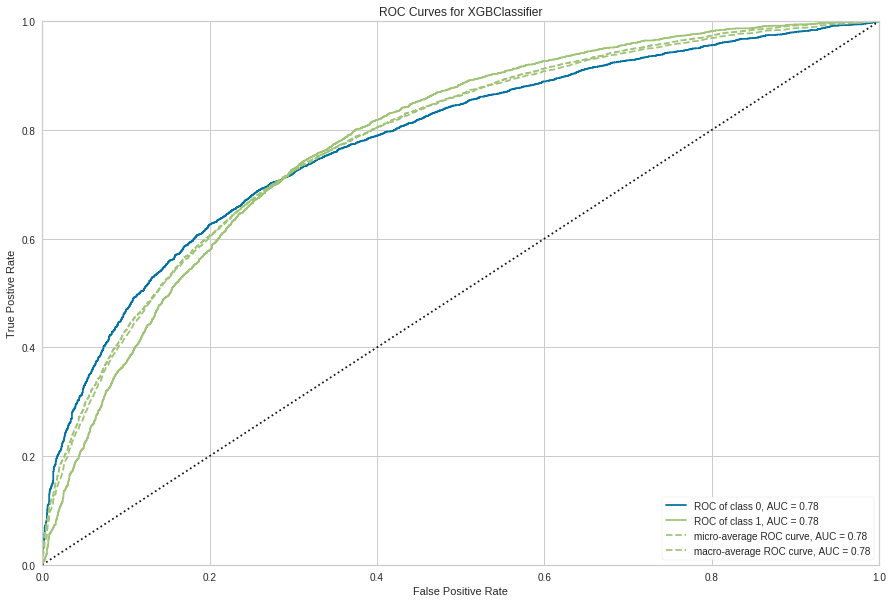

In [15]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

rocauc = ROCAUC(xgc, size=(1080, 720), classes=class_labels)

rocauc.score(X_test, y_test)
r = rocauc.poof()

The AUC = 0.78, not bab for a classification model. However, we should make further analysis to reduce variance and bias in the model. At the moment, we move forward without the process of tuning model.

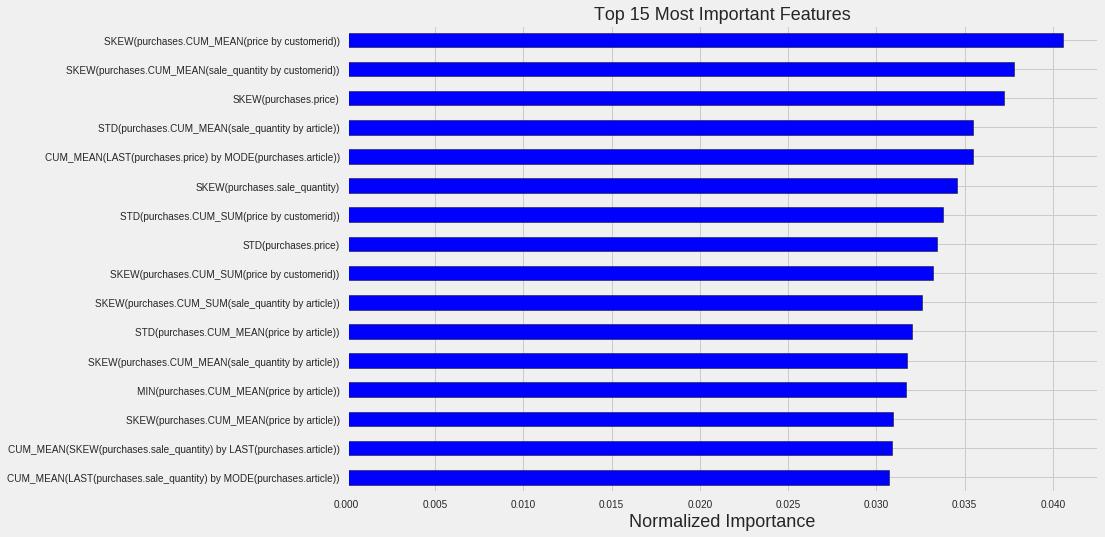

In [16]:
from utils import plot_feature_importances

fi = pd.DataFrame({'feature': list(X_train.columns), 'importance': xgc.feature_importances_})
xgc_fi = plot_feature_importances(fi)

Feature importance look pretty not 'business-oriented'.

### Explain predictions with SHAP

Here we use the Tree SHAP implementation integrated into XGBoost to explain the test dataset! Remember that there are a variety of explainer methods based on the type of models you are building. We estimate the SHAP values for a set of samples (test data)

In [19]:
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

In [20]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [21]:
print('Expected Value:', explainer.expected_value)

Expected Value: -0.28872147


In [22]:
X_test_disp.head()

STD(purchases.sale_quantity)  STD(purchases.price)  \
13618                      0.000000          24324.473273   
27479                      2.313017          85663.149626   
18321                      0.968451          98688.255405   
22976                      0.886288          37551.567664   
25590                      0.216505          37146.304885   

       MIN(purchases.sale_quantity)  MIN(purchases.price)  \
13618                         1.000               16500.0   
27479                         0.026                4000.0   
18321                         0.106                5000.0   
22976                         0.194                2500.0   
25590                         0.108               13500.0   

       SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
13618                            NaN                    NaN   
27479                       8.502935               4.098583   
18321                       3.560555               1.869272   
22976                       0.685612               3.360665   
25590                       2.989078              -1.005464   

       LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
13618               50900.00                              0.000000   
27479               33100.56                          38634.146341   
18321               35500.00                          94707.692308   
22976               20200.00                         115200.000000   
25590              123500.00                         419657.142857   

       DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
13618                          8                            3  ...   
27479                          5                            2  ...   
18321                          1                            2  ...   
22976                         25                            2  ...   
25590                          7                            2  ...   

       CUM_SUM(MEAN(purchases.price) by MODE(purchases.article))  \
13618                                       2.164925e+06           
27479                                       3.485602e+06           
18321                                       2.805240e+06           
22976                                       3.606392e+06           
25590                                       3.960507e+06           

       CUM_SUM(STD(purchases.sale_quantity) by MODE(purchases.article))  \
13618                                          61.806384                  
27479                                          81.695504                  
18321                                          77.996422                  
22976                                          79.183699                  
25590                                          96.424248                  

       CUM_SUM(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  \
13618                                       5.317284e+06                          
27479                                       1.102367e+07                          
18321                                       4.221633e+06                          
22976                                       6.695288e+06                          
25590                                       1.080804e+07                          

       CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
13618                                           1.091805                    
27479                                           1.345903                    
18321                                           1.810636                    
22976                                           1.195932                    
25590                                           1.139479                    

       CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
13618                                       52803.049639            
27479                                       56219.379839            
18321                  

In [23]:
labels.head(3)

0    1
1    1
2    0
Name: label, dtype: int64

In [72]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

In [25]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

In [26]:
shap.force_plot(explainer.expected_value, shap_values[:2000,:], X_test_disp.iloc[:2000,:])

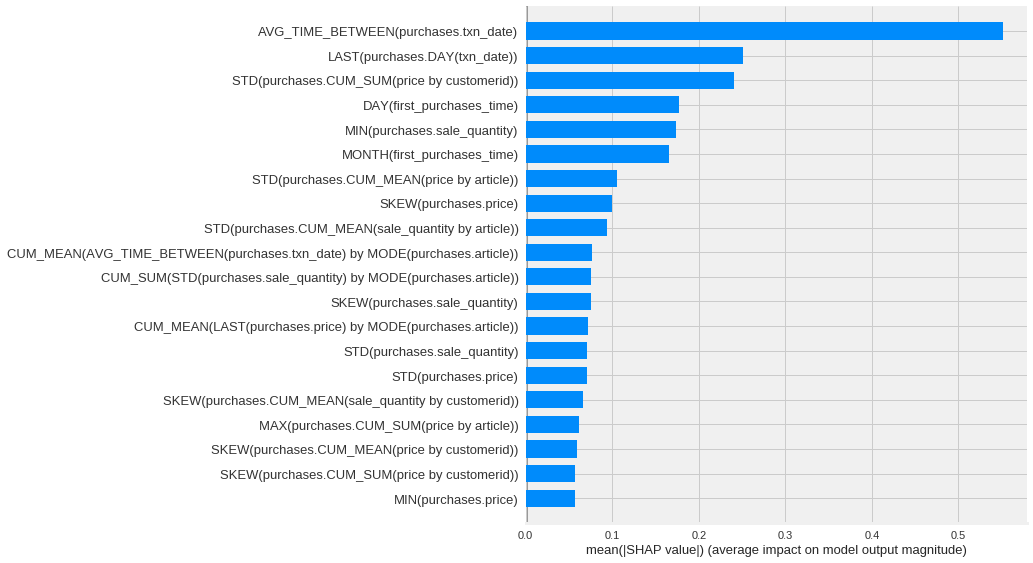

In [31]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

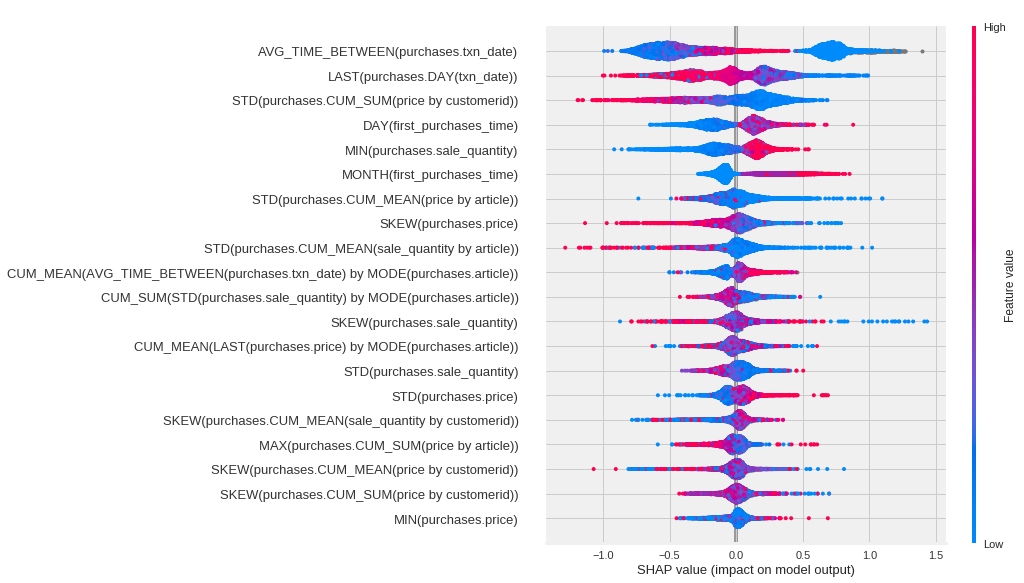

In [34]:
shap.summary_plot(shap_values, X_test)

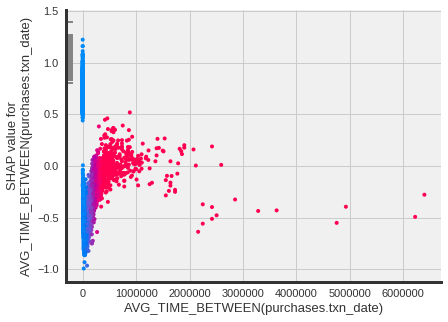

In [68]:
shap.dependence_plot(ind='AVG_TIME_BETWEEN(purchases.txn_date)', interaction_index='AVG_TIME_BETWEEN(purchases.txn_date)',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

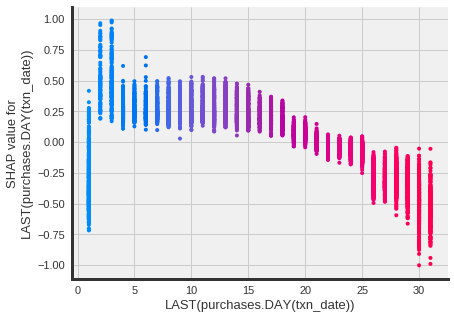

In [70]:
shap.dependence_plot(ind='LAST(purchases.DAY(txn_date))', interaction_index='LAST(purchases.DAY(txn_date))',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### Discussion Problem

To answer the question about which customers to send promotional e-mails to next month, based on the
model. We write a function to predict which cuctomer is likely to churn with months.

In [35]:
data.head(3)

STD(purchases.sale_quantity)  STD(purchases.price)  \
0                      1.204159         101126.358445   
1                      0.566264          91006.855807   
2                      1.610406          24654.705545   

   MIN(purchases.sale_quantity)  MIN(purchases.price)  \
0                         1.000                3900.0   
1                         0.162                4000.0   
2                         1.000                3900.0   

   SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
0                       1.628182               1.244193   
1                       1.524211               4.488398   
2                       1.815523               2.815737   

   LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
0               160000.0                              0.000000   
1                56800.0                          74482.758621   
2                20300.0                              0.000000   

   DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
0                         27                            2  ...   
1                          1                            2  ...   
2                         22                            2  ...   

   CUM_SUM(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500           
1                                      132456.031167           
2                                      152827.459738           

   CUM_SUM(STD(purchases.sale_quantity) by MODE(purchases.article))  \
0                                           1.204159                  
1                                           1.770424                  
2                                           3.380830                  

   CUM_SUM(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  \
0                                           0.000000                          
1                                       74482.758621                          
2                                       74482.758621                          

   CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
0                                                1.0                    
1                                                1.0                    
2                                                1.0                    

   CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500            
1                                       66228.015583            
2                                       50942.486579            

   CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
0                                      101126.358445           
1                                       96066.607126           
2                                       72262.639932           

   CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
0                                           1.628182                    
1                                           1.576197                    
2                                           1.655972                    

   CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
0                                      160000.000000            
1                                      108400.000000            
2                                       79033.333333            

   CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
0                                           1.244193            
1                                           2.866295            
2                                           2.849442            

   CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  
0                                           0.000000                          
1                                       37241.379310                          
2                                       24827.586207    

In [37]:
final_matrix_selection.head(3)

STD(purchases.sale_quantity)  STD(purchases.price)  \
0                      1.204159         101126.358445   
1                      0.566264          91006.855807   
2                      1.610406          24654.705545   

   MIN(purchases.sale_quantity)  MIN(purchases.price)  \
0                         1.000                3900.0   
1                         0.162                4000.0   
2                         1.000                3900.0   

   SKEW(purchases.sale_quantity)  SKEW(purchases.price)  \
0                       1.628182               1.244193   
1                       1.524211               4.488398   
2                       1.815523               2.815737   

   LAST(purchases.price)  AVG_TIME_BETWEEN(purchases.txn_date)  \
0               160000.0                              0.000000   
1                56800.0                          74482.758621   
2                20300.0                              0.000000   

   DAY(first_purchases_time)  MONTH(first_purchases_time)  ...  \
0                         27                            2  ...   
1                          1                            2  ...   
2                         22                            2  ...   

   CUM_MEAN(LAST(purchases.sale_quantity) by MODE(purchases.article))  \
0                                                1.0                    
1                                                1.0                    
2                                                1.0                    

   CUM_MEAN(MEAN(purchases.price) by MODE(purchases.article))  \
0                                       83601.562500            
1                                       66228.015583            
2                                       50942.486579            

   CUM_MEAN(STD(purchases.price) by MODE(purchases.article))  \
0                                      101126.358445           
1                                       96066.607126           
2                                       72262.639932           

   CUM_MEAN(SKEW(purchases.sale_quantity) by LAST(purchases.article))  \
0                                           1.628182                    
1                                           1.576197                    
2                                           1.655972                    

   CUM_MEAN(LAST(purchases.price) by MODE(purchases.article))  \
0                                      160000.000000            
1                                      108400.000000            
2                                       79033.333333            

   CUM_MEAN(SKEW(purchases.price) by LAST(purchases.article))  \
0                                           1.244193            
1                                           2.866295            
2                                           2.849442            

   CUM_MEAN(AVG_TIME_BETWEEN(purchases.txn_date) by MODE(purchases.article))  \
0                                           0.000000                           
1                                       37241.379310                           
2                                       24827.586207                           

   label        time    customerid  
0      1  2018-03-01  Y2NgaWlpYA==  
1      1  2018-03-01  Y2NgamRpZA==  
2      0  2018-03-01      Y2NgbWFn  

[3 rows x 42 columns]

In [71]:
def predict_month(month, final_matrix_selection, return_probs = False):
    """Apply trained model on single month"""
    
    final_matrix_selection['time'] = pd.to_datetime(final_matrix_selection['time'])
    final_matrix_selection['month'] = final_matrix_selection['time'].dt.month
    
    # Features
    month_train = final_matrix_selection[final_matrix_selection['time'].dt.month == month].drop(columns = ['customerid', 'time',
                                                                                     'month', 'label'])
    customer_labels = final_matrix_selection.loc[final_matrix_selection['month'] == month, ['month','customerid']]
    predictions = xgc.predict(month_train)
    
    # Add to final dataframe 
    customer_labels['prediction'] = predictions
    
    return customer_labels

In [65]:
predict_month(4, final_matrix_selection).head()

month    customerid  prediction
9978      4  Y2NgaWJoYw==           1
9979      4  Y2NgaWlpYA==           0
9980      4  Y2NgamRpZA==           0
9981      4      Y2NgamVj           1
9982      4  Y2Ngb2FpYg==           1

## Next Steps

From the our analytic project, it is good to recap some important findings in the views of business reviews and modeling process as follows.

### Business Actions

#### Business actions and review

1. Review business performance on customer onboarding (1 month after first purchase)
2. Explain abnormal number of new customers in February
3. Take into account which customers should be sent promotional emails in next months in part 4.

#### Modeling process:
1. Exploratory data analysis

  * Adding more exploratory data analysis because it should be helpfull in the following process of modeling.

2. Modeling process

  * Review how we define churn customer
  * Adopt model optimization process 